In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
def synthetic_data(w, b, num_examples):
    """generate y = Xw + b + noise"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
# generate a dataset
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000) 

In [8]:
# for i in range(10):
#     print('features:', features[i], '\nlabel:', labels[i])
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 0.2471, -0.0131]) 
label: tensor([4.7303])


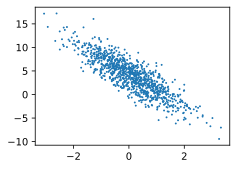

In [6]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

In [10]:
def data_iter(batch_size, features, labels):
    """生成小批量的特征和标签"""
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [15]:
batch_size = 10
count = 0
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    count += 1
    if count == 2:
        break

tensor([[-1.8531, -0.2487],
        [-0.5526,  1.7512],
        [ 0.4999, -0.3655],
        [-2.1999,  0.7207],
        [ 1.0441, -0.1056],
        [-0.6955, -1.2580],
        [ 1.7741, -1.0111],
        [-0.4304, -0.7261],
        [-0.3357,  1.3620],
        [ 0.5308,  0.1167]]) 
 tensor([[ 1.3405],
        [-2.8673],
        [ 6.4308],
        [-2.6470],
        [ 6.6499],
        [ 7.1141],
        [11.1826],
        [ 5.8152],
        [-1.0941],
        [ 4.8802]])
tensor([[ 0.4696,  1.3259],
        [-0.3117, -0.5858],
        [-0.2129,  1.8733],
        [-0.9837, -1.2790],
        [-1.0641,  0.1436],
        [ 1.6756,  0.4654],
        [ 0.8950, -0.1145],
        [ 0.8192, -2.3141],
        [-0.5411,  1.7955],
        [-0.9744, -0.1273]]) 
 tensor([[ 0.6455],
        [ 5.5832],
        [-2.6118],
        [ 6.6047],
        [ 1.5841],
        [ 5.9742],
        [ 6.3716],
        [13.7061],
        [-2.9581],
        [ 2.6933]])


这种迭代的实现方法实际上执行效率很低。因为它要求我们将所有数据加载到内存，并执行大量的随机访问。在深度学习框架中实现的内置迭代器的效率高很多。

In [18]:
# Define model
def linreg(X, w, b):
    """linear regression model"""
    return torch.matmul(X, w) + b

In [22]:
t_X = torch.tensor([[-1.8531, -0.2487],
        [-0.5526,  1.7512],
        [ 0.4999, -0.3655],
        [-2.1999,  0.7207],
        [ 1.0441, -0.1056],
        [-0.6955, -1.2580],
        [ 1.7741, -1.0111],
        [-0.4304, -0.7261],
        [-0.3357,  1.3620],
        [ 0.5308,  0.1167]])
t_w = torch.tensor([[ 0.0072],
         [-0.0064]])
t_b = 1
t_y = torch.matmul(t_X, t_w) + b
t_y.shape

torch.Size([10, 1])

In [37]:
# Define loss function
def squared_loss(y_hat, y):
    """squared error loss"""
    return (1 / 2) * (y_hat - y.reshape(y_hat.shape)) ** 2

In [20]:
# Define optimize algorithm
def sgd(params, lr, batch_size):
    """mini-batch stochastic gradient descent"""
    with torch.no_grad():  # 在其内部的操作不会被记录到计算图中(?)
        for param in params: # [w, b]
            param -= lr * param.grad / batch_size
            param.grad.zero_()  # 梯度清零，因为pytorch在反向传播时会累计梯度，而不是自动覆盖


In [41]:
# Train
lr = 0.03
num_epochs = 3
net = linreg  # 表示net时linreg的一个别名，在这种情况下，linreg并没有被调用
loss = squared_loss

# Initialize w, b
# w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
# b = torch.zeros(1, requires_grad=True)
w = torch.zeros_like(true_w, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # l.shape = (batch_size, 1)
        l.sum().backward()  # 变成标量后，调用backward方法（torch.Tensor对象的方法）可以计算该标量损失值对于所有需要梯度的张量的梯度
        sgd([w, b], lr, batch_size)  # 使用梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)  # 计算更新一个epoch后的损失
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.058772
epoch 2, loss 0.000275
epoch 3, loss 0.000052


In [35]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0008, -0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)
